# 합병증 분류 예측 모델링
- Date : 2022/8/11 ~ 2022/8/24
- Data : full_data_220812.xlsx
- Process : Data load ->  EDA -> Data preprocessing & engineering -> Modeling
- Model : 
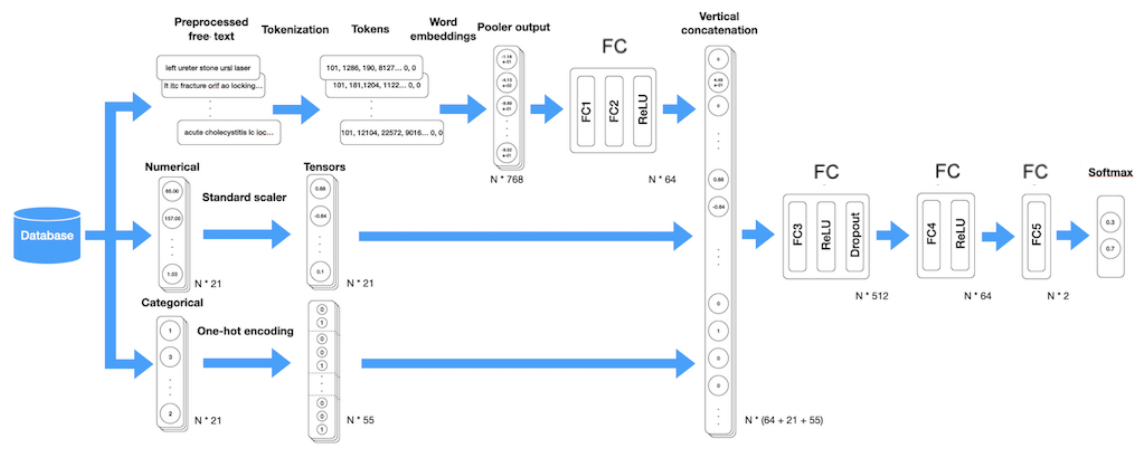
- Reference : 
  - [Predicting Postoperative Mortality With Deep Neural Networks
and Natural Language Processing: Model Development and
Validation](https://dmmj3ljielax6.cloudfront.net/upload/chat/cc1e7aea-bb3d-4127-a9e9-cf61504c8be6.pdf)
  - [국민건강영양조사를 활용한 대사증후군 유병 예측모형
개발을 위한 융복합 연구](https://koreascience.kr/article/JAKO201609562998521.pdf)
  - [Publicly Available Clinical BERT Embeddings](https://arxiv.org/pdf/1904.03323.pdf)

## Colab & Drive Setting

In [ ]:
# google drive 연동
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/숨고/윤현규님(합병증 예측)/') # 해당 path는 환경에 맞게 변경해야 함

Mounted at /content/drive/


In [ ]:
# tensorflow를 import 하고, 현재 colab에서 gpu 구동이 되고 있는지 테스트 하는 코드
# Found GPU at: /device:GPU ~ 가 뜨면 성공

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Import Library

In [ ]:
!pip install transformers

import pandas as pd, numpy as np, random, re, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler 
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')

# tensorflow/keras
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from keras.layers.advanced_activations import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 70.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Load

In [ ]:
data = pd.read_excel("full_data_220812.xlsx")
data = data[[i for i in data.columns if (i!='asa')&(i!='second_outcome')]]

In [ ]:
data.head(10)

,caseid,first_outcome,age,sex,wt,ht,bm,atype,hem,wb,...,al,tb,got,gpt,sod,pot,gl,dept,name,diagnosis
0,1,1,76.0,1,64.80,150.0,28.800000,0,9.7,13.10,...,2.3,0.9,19.0,22.0,126.0,3.7,95.0,GS,Explorative laparotomy,peritonitis
1,2,0,53.0,1,48.75,158.0,19.528120,0,12.3,8.40,...,4.3,1.9,24.0,25.0,135.0,4.7,128.0,GS,Explorative Laparotomy(Gyn),Mechanical Ileus
2,3,0,72.0,0,64.60,170.0,22.352941,0,12.0,5.80,...,4.0,0.7,16.0,19.0,143.0,4.4,121.0,OL,Rigid Bronchoscopic Excision of Tracheal or B...,lung cancer
3,4,0,25.0,0,86.45,182.3,26.013073,0,16.2,5.20,...,4.3,0.9,20.0,50.0,143.0,4.5,113.0,TS,Video-assisted thoracoscopic surgery(VATS),pneumothorax
4,5,0,22.0,1,53.10,NaN,NaN,1,12.6,8.20,...,4.2,1.1,8.0,17.0,136.0,4.1,139.0,GS,Appendectomy,acute appendicitis
5,6,0,33.0,0,63.95,NaN,NaN,0,14.9,23.20,...,4.4,1.9,16.0,43.0,139.0,4.2,109.0,GS,Appendectomy,acute appendicitis
6,7,0,62.0,1,42.70,147.0,19.760285,0,11.1,10.23,...,3.7,0.4,17.0,6.0,144.0,4.4,118.0,OS,Revision of all components of total knee repla...,"s/p Infection, TKRA, Lt"
7,8,0,27.0,1,66.90,171.0,22.878835,1,12.7,5.51,...,4.0,0.6,14.0,8.0,137.0,4.0,84.0,OS,lateral release and medial plication for patel...,"Recurrent Subluxation Of Patella, Rt."
8,9,0,38.0,1,64.65,NaN,NaN,0,10.3,21.41,...,1.8,0.5,18.0,12.0,130.0,3.8,222.0,OG,Explorative Laparotomy(Gyn),postpartum hemorrhage
9,10,0,66.0,1,60.00,146.5,27.956062,1,12.0,5.74,...,4.5,0.6,20.0,18.0,143.0,4.2,89.0,OS,Total hip replacement arthroplasty (THRA),DA. hip. Rt


## Fill NA

In [ ]:
id = ['caseid']
pred_col = ['first_outcome']
cate_col = ['sex','atype','dept']
nlp_col = ['name','diagnosis']
num_col = [i for i in data.columns if (i not in id)&(i not in cate_col)&(i not in nlp_col)]

# fill na with median
data[num_col] = data[num_col].fillna(data[num_col].median())

## Feature Engineering

In [ ]:
# 논문 참고
# 1. 수치형 변수는 standard scaling 진행
# 1-1. 수치형 변수의 결측치는 중앙값 대체 진행(이상치 또한 중앙값 대체 진행)
# 2. 범주형 변수는 더미화 진행 
# 2-1. 범주형 변수의 결측치는 과반수 이상 범주로 대체 
# 3. 텍스트 변수는 stopword 제거 등의 nlp 과정 진행
# 3-1 전처리된 텍스트는 Bert Tokenizer를 통해 토큰화 한 후 bio clinical bert를 통해 768차원의 벡터로 임베딩 진행 
#    -> train/test 별 각 1000, 500개 sampling 하여 t-SNE를 통해 시각화 후, 정답과 예측률 비교하여 text가 예측률에 영향을 미쳤는지 봄
# 4 cross entropy loss function에서 class 불균형 보정을 위해 inverse-frequency class weighting 사용됨 
# 5 batch size는 64, optimizer는 AdamW 사용, lr은 0.00002 사용 val loss 기준 early stopping 사용 
# 6 심각한 class 불균형으로 인해(1562/121,313), precision, recall, speicific, f1 score, AUPRC 등 사용 
# 6-1 최종 평가는 test set 1000번 bootstrap sample 후, metric별 95% 신뢰구간까지 구함
# 7 제안된 BERT-DNN 모델이 모든 metric에서 좋은 성능을 보이진 않음
# 7-1 AUROC, AUPRC, F1-score, recall, specificity는 대부분 높음
# 7-2 도메인 관점에서 중요할 수 있는 Precision은 오히려 머신러닝 알고리즘이 높음(내 주관 판단)
# 8 한계점
# 8-1 클래스의 불균형이 매우 심함
# 8-2 전자건강기록(EHR)을 사용하여 측정된 데이터에 오류가 많았음(결측치, 이상치 포함)
# 8-3 모든 기록은 하나의 대형 메디컬 센터에서 수집되었으므로 일반화 가능성에도 검토해볼 필요가 있음 

In [ ]:
data_copied = data.copy()

In [ ]:
# Numerical Features Engineering

# age
data_copied['age_group_1'] = data_copied['age'].apply(lambda x : 1 if x<30 else 0) # 20대 이하
data_copied['age_group_2'] = data_copied['age'].apply(lambda x : 1 if (x>=30) & (x<40) else 0) # 30대
data_copied['age_group_3'] = data_copied['age'].apply(lambda x : 1 if (x>=40) & (x<50) else 0) # 40대
data_copied['age_group_4'] = data_copied['age'].apply(lambda x : 1 if (x>=50) & (x<60) else 0) # 50대 
data_copied['age_group_5'] = data_copied['age'].apply(lambda x : 1 if (x>=60) & (x<70) else 0) # 60대
data_copied['age_group_6'] = data_copied['age'].apply(lambda x : 1 if (x>=70) & (x<80) else 0) # 70대
data_copied['age_group_7'] = data_copied['age'].apply(lambda x : 1 if (x>=80) else 0) # 80대 이상
data_copied = data_copied.drop(['age'], axis=1)

# wt
data_copied['wt_group_1'] = data_copied['wt'].apply(lambda x : 1 if x<40 else 0) # 40 미만
data_copied['wt_group_2'] = data_copied['wt'].apply(lambda x : 1 if (x>=40) & (x<50) else 0) # 40이상 50미만
data_copied['wt_group_3'] = data_copied['wt'].apply(lambda x : 1 if (x>=50) & (x<60) else 0) # 50이상 60미만
data_copied['wt_group_4'] = data_copied['wt'].apply(lambda x : 1 if (x>=60) & (x<70) else 0) # 60이상 70미만
data_copied['wt_group_5'] = data_copied['wt'].apply(lambda x : 1 if (x>=70) & (x<80) else 0) # 70이상 80미만
data_copied['wt_group_6'] = data_copied['wt'].apply(lambda x : 1 if (x>=80) & (x<90) else 0) # 80이상 90미만
data_copied['wt_group_7'] =  data_copied['wt'].apply(lambda x : 1 if x>=90 else 0)  # 90 이상
data_copied = data_copied.drop(['wt'], axis=1)

# hem, pot 제외
data_copied = data_copied.drop(['hem', 'pot'], axis=1)

In [ ]:
# Categorical Features Engineering

# dept
data_copied['dept_separate'] = data_copied['dept'].apply(lambda x : x if (x=='TS') | (x=='UR') else 'Others')
data_copied = data_copied.drop(['dept'], axis=1)

# one-hot-encoding
def onehot(df, col):
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(df[col].values.reshape(-1,1))
    onehot_data = pd.DataFrame(onehot_data, columns=[col + "_" + i for i in onehot.categories_])
    df = pd.concat([df, onehot_data], axis=1)
    df = df.drop([col], axis=1)

    return df

data_copied = onehot(data_copied, "dept_separate")

In [ ]:
# numeric feature scaling
num_col = ['bm','ht','wb','hc','pl','bu','cr','in','ap','al','tb','got','gpt','sod','gl']
mm = MinMaxScaler()
mm_data = mm.fit_transform(data_copied[num_col])
mm_data = pd.DataFrame(mm_data, columns = num_col)
data_copied[num_col] = mm_data

In [ ]:
# NLP

# name 변수와 diagnosis 변수 내 특수문자 제거 
data_copied['name_rmv'] = data_copied['name'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)
data_copied['diagnosis_rmv'] = data_copied['diagnosis'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)

# stopword 제거
def NLP_function(sentence, stopwords):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if (not w.lower() in stopwords)]
    final_sentence = " ".join(filtered_sentence)

    return final_sentence

stop_words = set(stopwords.words('english'))
data_copied['name_rmv'] = data_copied['name_rmv'].apply(lambda x : NLP_function(x, stop_words))
data_copied['diagnosis_rmv'] = data_copied['diagnosis_rmv'].apply(lambda x : NLP_function(x, stop_words))

data_copied = data_copied.drop(['name', 'diagnosis'], axis=1)

## Sampling

In [ ]:
# undersampling(sampling_strategy = minority_num / majority_num)
rus = RandomUnderSampler(sampling_strategy = 1, random_state=20220820)
X_res, y_res = rus.fit_resample(data_copied.drop(['first_outcome'],axis=1), data_copied['first_outcome'])

total_data = pd.concat([X_res, pd.DataFrame(y_res)], axis=1).reset_index(drop=True)
total_data.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


,caseid,sex,ht,bm,atype,wb,hc,pl,bu,cr,...,wt_group_4,wt_group_5,wt_group_6,wt_group_7,"(dept_separate_Others,)","(dept_separate_TS,)","(dept_separate_UR,)",name_rmv,diagnosis_rmv,first_outcome
0,64348,0,0.602222,0.251747,0,0.003763,0.376934,0.026942,0.089431,0.179747,...,1,0,0,0,0.0,1.0,0.0,Lt VATS W R Lobectomy double lumen,metastatic lung Left,0
1,78668,0,0.638889,0.221130,0,0.003472,0.462729,0.023443,0.089431,0.217722,...,1,0,0,0,1.0,0.0,0.0,Repair hernia anterior abdominal wall without ...,Hepatocellular carcinoma,0
2,10185,0,0.755556,0.246384,0,0.010837,0.609001,0.102169,0.073171,0.243038,...,0,1,0,0,0.0,1.0,0.0,Video assisted thoracoscopic surgery VATS B do...,giant bullae lung,0
3,67316,1,0.362222,0.259892,0,0.008802,0.576653,0.080476,0.146341,0.146835,...,0,0,0,0,0.0,1.0,0.0,VATS RUL W R VATS LULobectomy double lumen,nonsmall cell lung cancer Left,0
4,34311,1,0.610000,0.162449,0,0.011257,0.482419,0.093772,0.081301,0.192405,...,0,0,0,0,1.0,0.0,0.0,microvascular decompression,hemifacial spasm,0
5,150011,0,0.676667,0.321731,0,0.011435,0.540084,0.104269,0.121951,0.172152,...,0,1,0,0,1.0,0.0,0.0,Totally laparoscopic total gastrectomy standar...,Advanced gastric cancer,0
6,146999,1,0.487778,0.246943,0,0.010030,0.472574,0.080126,0.105691,0.141772,...,0,0,0,0,1.0,0.0,0.0,Laparoscopy assisted distal gastrectomy modifi...,Early gastric cancer,0
7,129738,0,0.377778,0.119804,0,0.010030,0.575246,0.087474,0.097561,0.293671,...,0,0,0,0,1.0,0.0,0.0,Removal foreign body plate FBR proximal femur Rt,Hypophosphatemic rickets,0
8,9335,1,0.477778,0.340352,1,0.023273,0.440225,0.099370,0.146341,0.344304,...,1,0,0,0,1.0,0.0,0.0,Emergency Cesarean section lower uterine segme...,Severe preeclampsia,0
9,156017,1,0.466667,0.246005,1,0.006816,0.440225,0.110917,0.097561,0.177215,...,0,0,0,0,1.0,0.0,0.0,TKRA total knee replacement arthroplasty right...,Degenerative arthritis knee,0


## Embedding

In [ ]:
# Sentence embedding by 
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def embedding(name_data, diag_data):
    name_list_data = name_data.values.reshape(-1).tolist()
    diag_list_data = diag_data.values.reshape(-1).tolist()
    name_result = np.zeros((1,768))
    diag_result = np.zeros((1,768))
    for i in range(0,len(name_list_data),100):
        print(i)
        name_encoded_input = tokenizer(name_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        name_model_output = model(**name_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        name_result = np.concatenate((name_result,name_model_output.pooler_output.detach().numpy()), axis=0)
        del name_model_output

        diag_encoded_input = tokenizer(diag_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        diag_model_output = model(**diag_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        diag_result = np.concatenate((diag_result,diag_model_output.pooler_output.detach().numpy()), axis=0)
        del diag_model_output

    return (name_result[1:,:], diag_result[1:,:])

name_embedding, diag_embedding = embedding(total_data['name_rmv'], total_data['diagnosis_rmv'])

total_data = total_data.drop(['name_rmv', 'diagnosis_rmv'], axis=1) 

In [ ]:
# save
data_processed = total_data.copy()
data_processed.to_csv('./result/processed data/data_5_5_processed.csv', index=False)

with open('./result/embedding data/name_5_5_embedding.pickle', 'wb') as f:
    pickle.dump(name_embedding, f)

with open('./result/embedding data/diag_5_5_embedding.pickle', 'wb') as f:
    pickle.dump(diag_embedding, f)

## Data loading for training


In [ ]:
data_processed = pd.read_csv('./result/processed data/data_5_5_processed.csv')

with open('./result/embedding data/name_5_5_embedding.pickle', 'rb') as f:
    name_embedding = pickle.load(f)

with open('./result/embedding data/diag_5_5_embedding.pickle', 'rb') as f:
    diag_embedding = pickle.load(f)

data_total = pd.concat([data_processed, pd.DataFrame(name_embedding), pd.DataFrame(diag_embedding)], axis=1)

## Modeling

In [ ]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(data_total.drop(['first_outcome'], axis=1), data_total['first_outcome'], test_size=0.2, random_state=20220822, stratify=data_total['first_outcome'])

train_id = x_train[['caseid']]
test_id = x_test[['caseid']]
x_train_mlp = x_train.iloc[:,1:35]
x_train_name_emb = x_train.iloc[:,35:803]
x_train_diag_emb = x_train.iloc[:,803:]
x_test_mlp = x_test.iloc[:,1:35]
x_test_name_emb = x_test.iloc[:,35:803]
x_test_diag_emb = x_test.iloc[:,803:]


In [ ]:
# model architecture

# parameters 
emb_input_size = len(x_train_name_emb.columns) # 768
mlp_input_size = len(x_train_mlp.columns) # 34
batch_size = 64
lr = 0.00002
epochs = 500

# name process
name_input = Input(shape=emb_input_size)
name_model = Dense(256, kernel_initializer='he_normal')(name_input)
name_model = ReLU()(name_model)
name_model = Dense(64, kernel_initializer='he_normal')(name_model)
name_model = ReLU()(name_model)

# diag. process
diag_input = Input(shape=emb_input_size)
diag_model = Dense(256, kernel_initializer='he_normal')(diag_input)
diag_model = ReLU()(diag_model)
diag_model = Dense(64, kernel_initializer='he_normal')(diag_model)
diag_model = ReLU()(diag_model)

# mlp process
mlp_input = Input(shape=mlp_input_size)

# concatenate
model = concatenate([name_model, diag_model, mlp_input])

# Dense layer
model = Dense(512,kernel_initializer='he_normal')(model)
model = ReLU()(model)
model = Dropout(0.5)(model)
model = Dense(64,kernel_initializer='he_normal')(model)
model = ReLU()(model)

# output layer
output = Dense(1, activation='sigmoid')(model) # sigmoid를 통한 확률 계산

# final model
model = Model(inputs=[name_input, diag_input, mlp_input], outputs=[output])


# optimizer
optimizer = optimizers.Adam(learning_rate=lr)

# model의 loss function, 사용할 optimizer, metirc 정의
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']) 

model.summary() # 모델 전체 아키텍처 출력

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 256)          196864      ['input_4[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 256)          196864      ['input_5[0][0]']                
                                                                                            

In [ ]:
# 학습 중 최상의 모델을 저장할 경로
best_weights_file="./result/model/weights.best.hdf5"

# 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)

# model 학습 설정 및 학습 진행(주입할 input, label 데이터/batch_size/epochs/모델 저장/학습과정출력여부/학습 중 val_loss를 계산할 데이터비율, epoch마다 셔플 여부)
history = model.fit([x_train_name_emb, x_train_diag_emb, x_train_mlp], y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, es],
        verbose=1,
        validation_split=0.2,
        shuffle=True)

Epoch 1/500
254/256 [============================>.] - ETA: 0s - loss: 0.7061 - accuracy: 0.5459
Epoch 1: val_accuracy improved from -inf to 0.64857, saving model to ./result/model/weights.best.hdf5
256/256 [==============================] - 2s 6ms/step - loss: 0.7058 - accuracy: 0.5461 - val_loss: 0.6536 - val_accuracy: 0.6486
Epoch 2/500
250/256 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6204
Epoch 2: val_accuracy improved from 0.64857 to 0.69161, saving model to ./result/model/weights.best.hdf5
256/256 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6210 - val_loss: 0.6239 - val_accuracy: 0.6916
Epoch 3/500
251/256 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.6637
Epoch 3: val_accuracy did not improve from 0.69161
256/256 [==============================] - 2s 7ms/step - loss: 0.6232 - accuracy: 0.6641 - val_loss: 0.6025 - val_accuracy: 0.6872
Epoch 4/500
253/256 [============================>.] - ETA

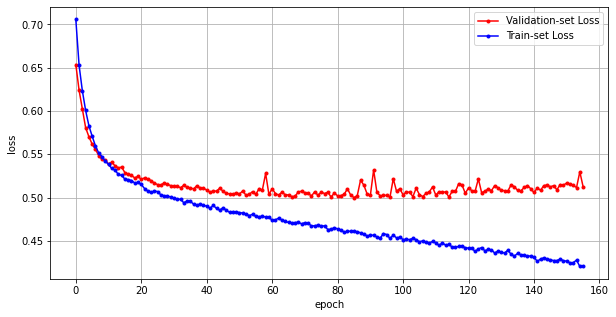

In [ ]:
# loss 그래프 출력
y_vloss = history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 전체 epoch 길이 저장(현재 500)

plt.figure(figsize=(10,5))
# validation loss에 대한 그래프 출력
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
# train loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 저장된 model load
best_weights_file="./result/model/weights.best.hdf5"
model.load_weights(best_weights_file)

#분리해둔 test set에 대하여 모델 정확도 반환
print('\nAccuracy: {:.4f}'.format(model.evaluate([x_test_name_emb, x_test_diag_emb, x_test_mlp], y_test)[1])) 

160/160 [==============================] - 0s 3ms/step - loss: 0.5004 - accuracy: 0.7660

Accuracy: 0.7660


## Evaluation

In [ ]:
 # Metrics for confusion matrix
y_pred = pd.DataFrame(model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]),columns=['predict_first_outcome'])
y_pred[y_pred['predict_first_outcome']>=0.5] = 1
y_pred[y_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2556
           1       0.78      0.74      0.76      2556

    accuracy                           0.77      5112
   macro avg       0.77      0.77      0.77      5112
weighted avg       0.77      0.77      0.77      5112



AUROC :  0.77


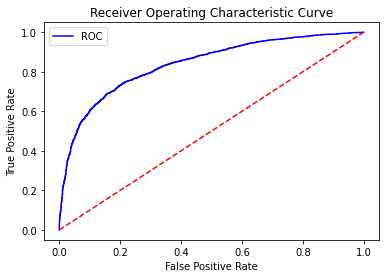

In [ ]:
# auroc
auroc_score = roc_auc_score(y_test, y_pred, average=None)
print("AUROC : ", round(auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp])
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)